## Load the data

### Imports and definitions

In [1]:
from pickle_workaround import pickle_load
from TfidfVectorizer import TfidfVectorizer
from vectorizer import tokenize, extract_requirements
from nlp import get_top_10_docs
from topics import search_models, plot_results
from data import get_query_corpus, get_connection

import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from wordcloud import WordCloud

from summaries import summarize_doc, summarize_doc_nmf
from IPython.display import Image, display

In [2]:
def topic_search(min_topics, max_topics, tfidf_corpus):

    time_start = time.time()
    costs, intertopic_similarities, interdocument_similarities = search_models(tfidf_corpus, min_topics, max_topics)
    time_dif = datetime.timedelta(seconds=round(time.time() - time_start))
    plot_results(min_topics, costs, intertopic_similarities, interdocument_similarities, time_dif, tfidf_corpus.shape)


def top7(topic_i, _W, _corpus, _doc_ids, _tfidf, _nmf, show_wordclouds=True, n_sentences=2):
    if show_wordclouds:
        display(Image(filename=f"../static/wordclouds/{topic_i}_nmf_wordcloud.png"))
        display(Image(filename=f"../static/wordclouds/{topic_i}_tfidf_wordcloud.png"))

    i = 0
    for doc, strength in get_top_10_docs(_W, topic_i):
        if i == 7:
            break
        print("*************************************************************")
        print(_doc_ids[doc], "-> STRENGTH:", round(strength * 100, 2))
        print(summarize_doc_nmf(_corpus[doc], _tfidf, _nmf, topic_i, n_sentences=n_sentences))
        #print(summarize_doc(doc))
        print()
        i += 1

        
def term_search(term, _H, _tfidf):
    term_i = _tfidf.vocabulary_[term]
    n_term_topics = np.count_nonzero(_H[:, term_i])
    term_topics = np.argsort(_H[:, term_i])[::-1][:n_term_topics]
    term_topics_strength = _H[:, term_i].flatten()[term_topics]
    for topic_i, strength in zip(term_topics, term_topics_strength):
        print(str(topic_i).rjust(2), "=", round(strength * 100, 2), "%")

In [3]:
_ = get_connection("/home/mark/Documents/missionmark/missionmark_db_creds")
tfidf = TfidfVectorizer(pickle_load("../output/CountVectorizer.pkl"), pickle_load("../output/TfidfTransformer.pkl"))
vocabulary = tfidf.get_feature_names()
print(len(vocabulary), "words")

Connecting to Postgres database...
 -> Connection successful!
Loading ../output/CountVectorizer.pkl from cache...
 -> ../output/CountVectorizer.pkl loaded!
Loading ../output/TfidfTransformer.pkl from cache...
 -> ../output/TfidfTransformer.pkl loaded!
21377 words


### Load dataset

In [10]:
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description LIKE('%REQUIREMENT%')
        """
doc_ids, corpus = get_query_corpus(query, True)
#corpus = np.array([extract_requirements(doc) for doc in corpus_full])
#corpus = corpus_full
tfidf_corpus = tfidf.transform(corpus)

Loading corpus...
 -> 8839 documents loaded!


In [90]:
nmf = pickle_load("../output/NMF.pkl")
H = nmf.components_
H_max = H.max(axis=1)
H_normalized = H / H_max.reshape((-1, 1))
# H_normalized = np.array([H[i] / H_max])
W = nmf.transform(tfidf_corpus)
W_max = W.max(axis=0)
W_normalized = W / W_max

print(H.shape[0], "topics")

Loading ../output/NMF.pkl from cache...
 -> ../output/NMF.pkl loaded!
42 topics


# Finding the HVAC topic(s)

### Find topics where "hvac" is significant

In [91]:
term_search("hvac", H_normalized, tfidf)

31 = 57.87 %
13 = 46.14 %
 2 = 4.69 %


The term "hvac" is most significant in topics 13 and 31 by a significant amount, and topic 2 to a lesser degree.

## Explore topics

Let's explore the wordclouds and top 10 documents for each of these three topics.  Only the two most significant sentences (in terms of their respective topics) will be displayed.

### Topic 13
By examining the output found below, we can label this topic as "Building Mechanical Systems Maintenance."  Specifically the following keywords are mentioned: mechanical, plumbing, HVAC, fire protection, and life safety systems.

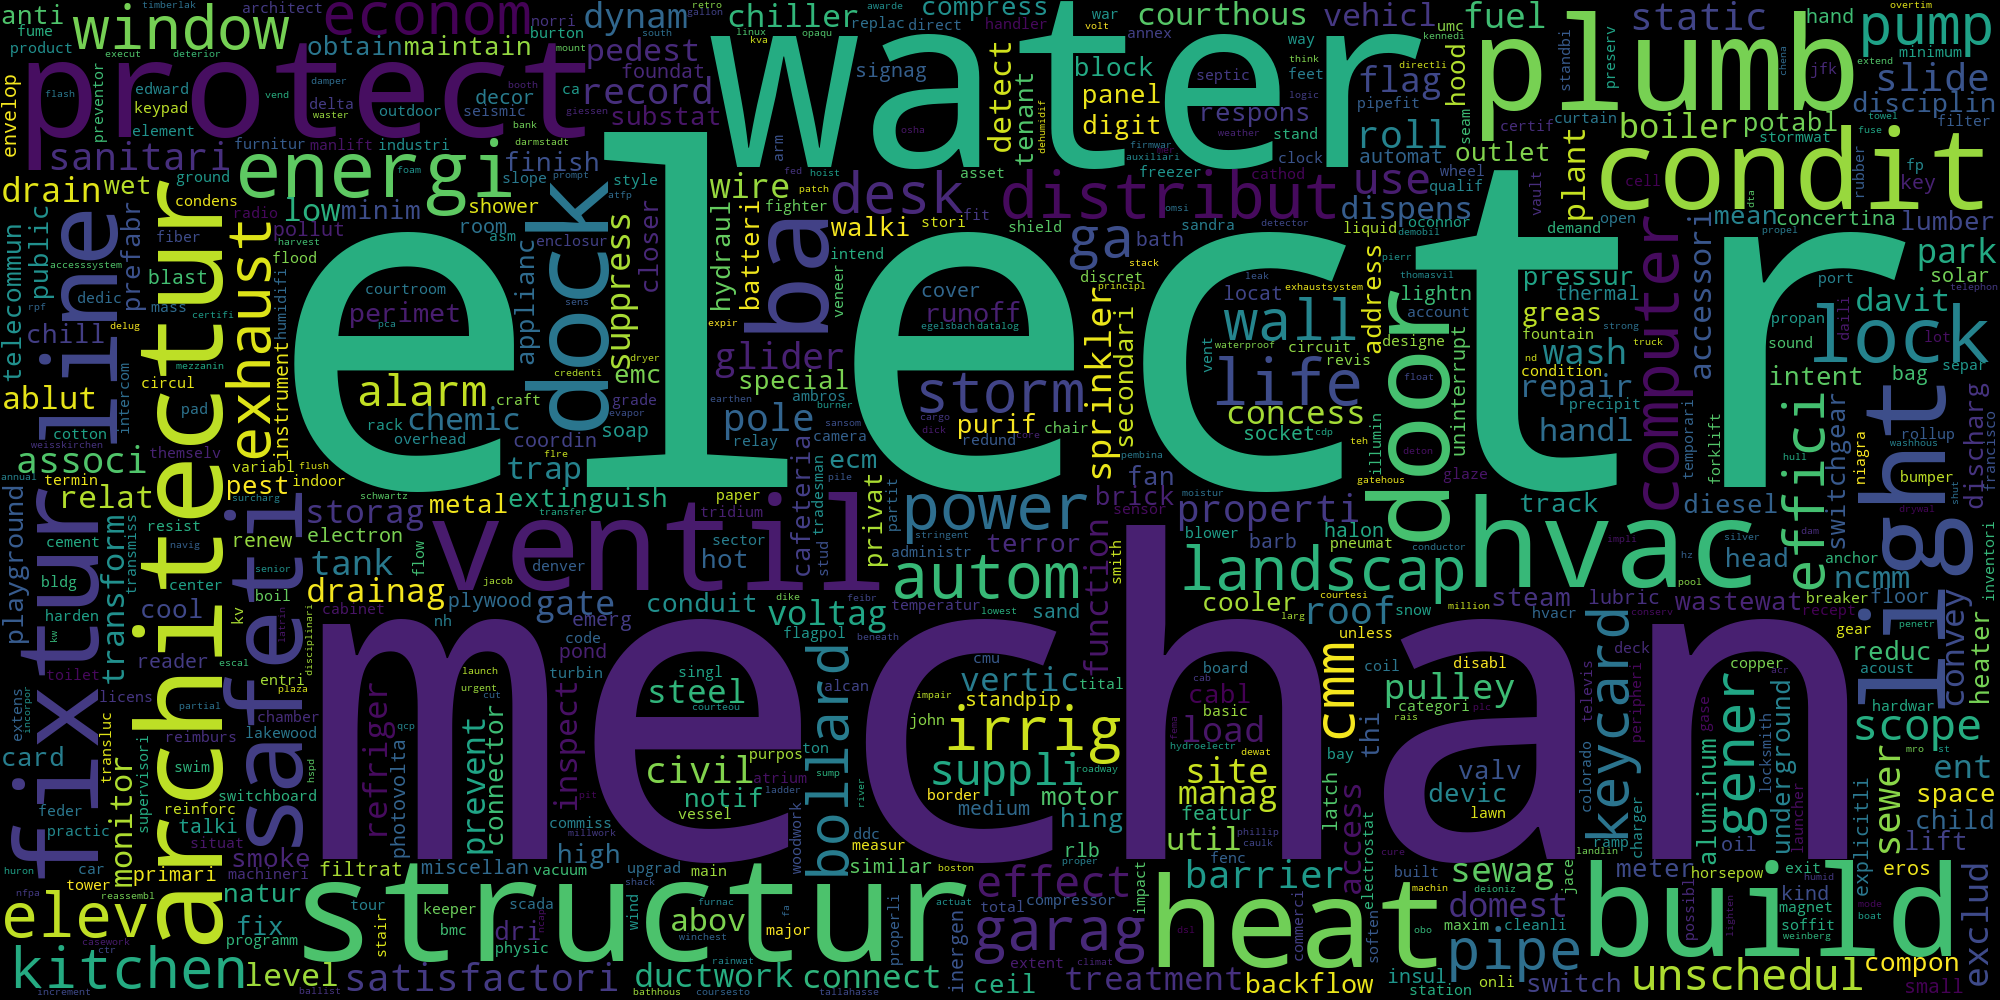

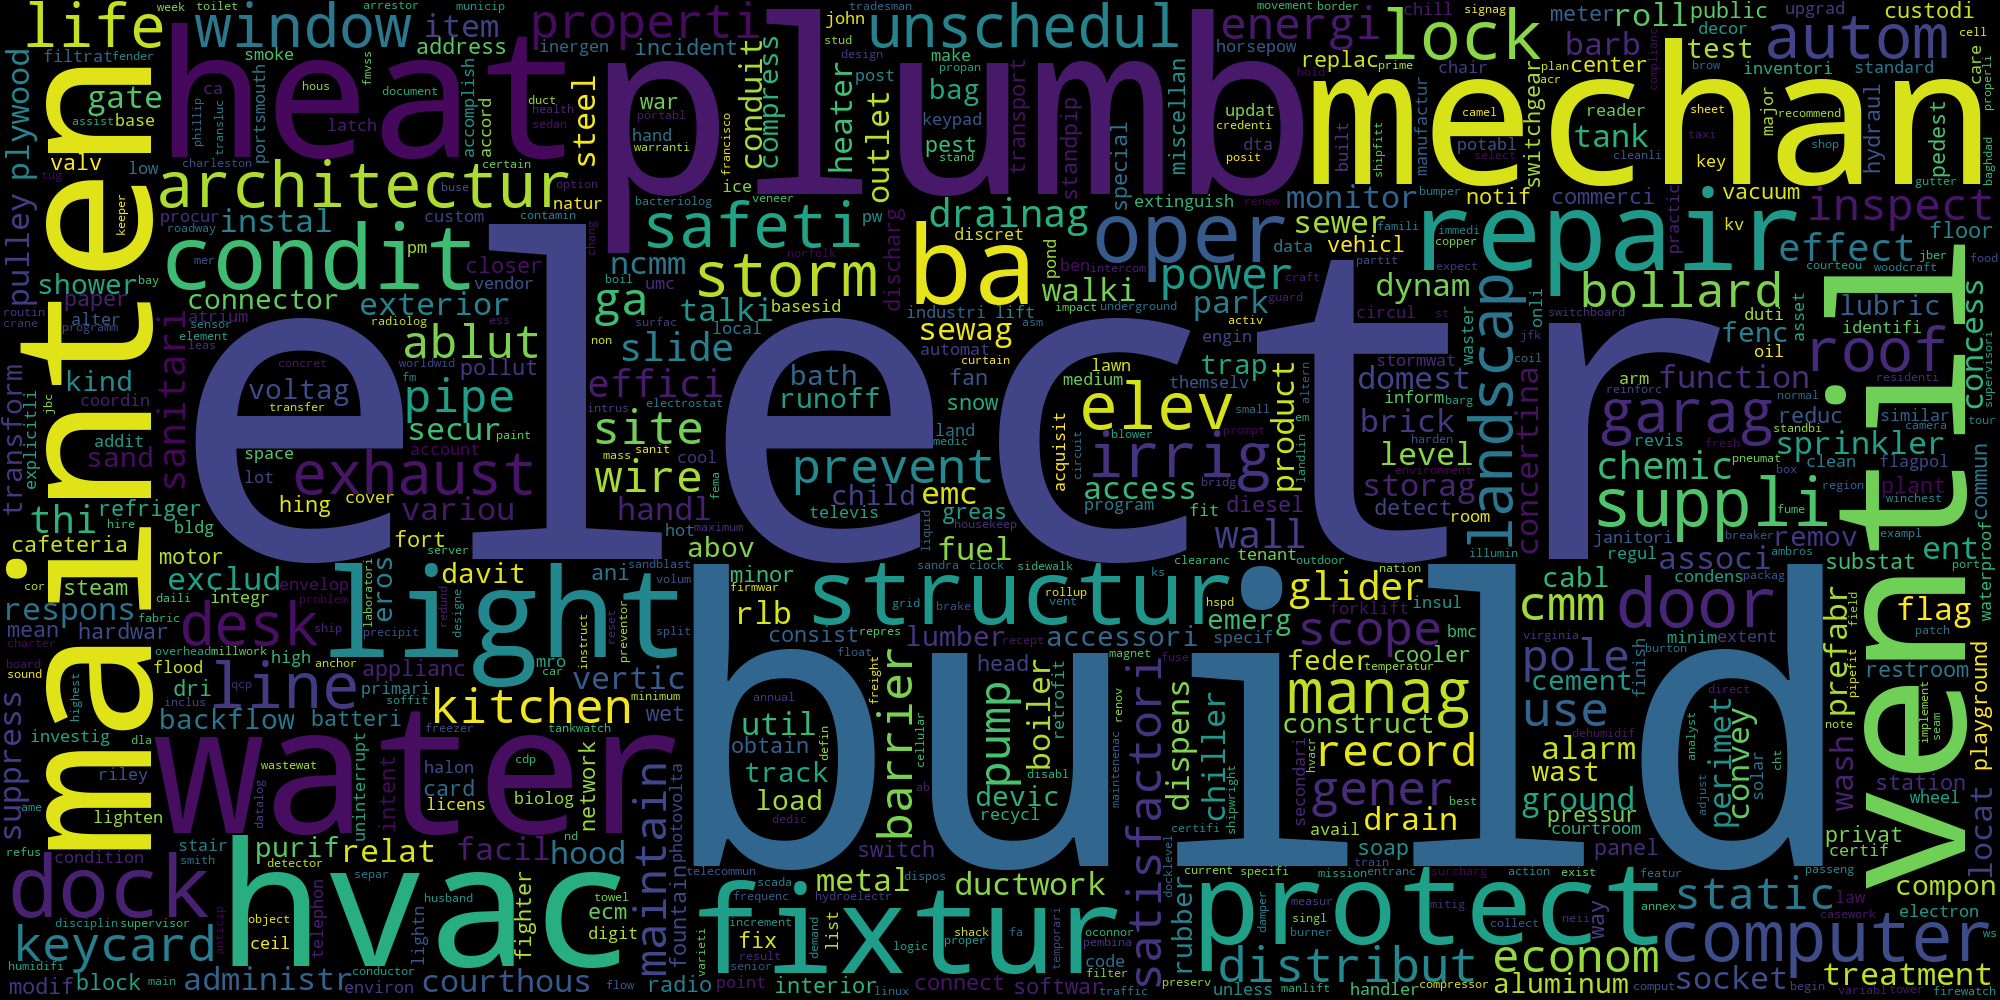

*************************************************************
165043 -> STRENGTH: 100.0
REQUIREMENTS                                                                    
The Contractor shall provide management, supervision, labor, materials, equipment, and supplies and is responsible for the efficient, effective, economical, and satisfactory operation, scheduled and unscheduled maintenance, and repair of the equipment and components of the systems listed in C.1.1 located within the property line of the building(s): 50 United Nations Plaza Federal Building CA0093ZZ
System REQUIREMENTS:
Electrical systems and equipment

(3 Year Testing Due Nov 2020)
Mechanical, plumbing, and heating, ventilation, exhaust systems and air conditioning (HVAC) systems and equipment
Fire protection and life safety systems and equipment throughout the building(s), to include all kitchen and cafeteria space fire protection systems
All Control systems that are within the scope of this Contract to include all Buil

PREVIOUS REQUIREMENTS                                                           
The requirements include providing all management, supervision, labor, materials, supplies, repair parts, tools and equipment necessary for the efficient, effective, economical, and satisfactory operation, scheduled and unscheduled maintenance, and repair of equipment and systems
This includes but is not limited to:
electrical systems and equipment
mechanical
plumbing
Heating, ventilation, exhaust systems and air conditioning (HVAC) systems and equipment
Fire protection and life safety systems and equipment (the inspection, testing, and maintenance of all fire protection systems)
Building Automation Systems (BAS)
Public address systems
Computerized lighting systems
Architectural and structural systems, fixtures, and equipment
Service request desk operations using a computerized maintenance management system (CMMS) if available or by other means as well as other administrative functions
Maintenance of lands

In [25]:
topic_i = 13
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

### Topic 31
By looking at the output below, we can label this topic as "General Repair, Renovation, and Construction."

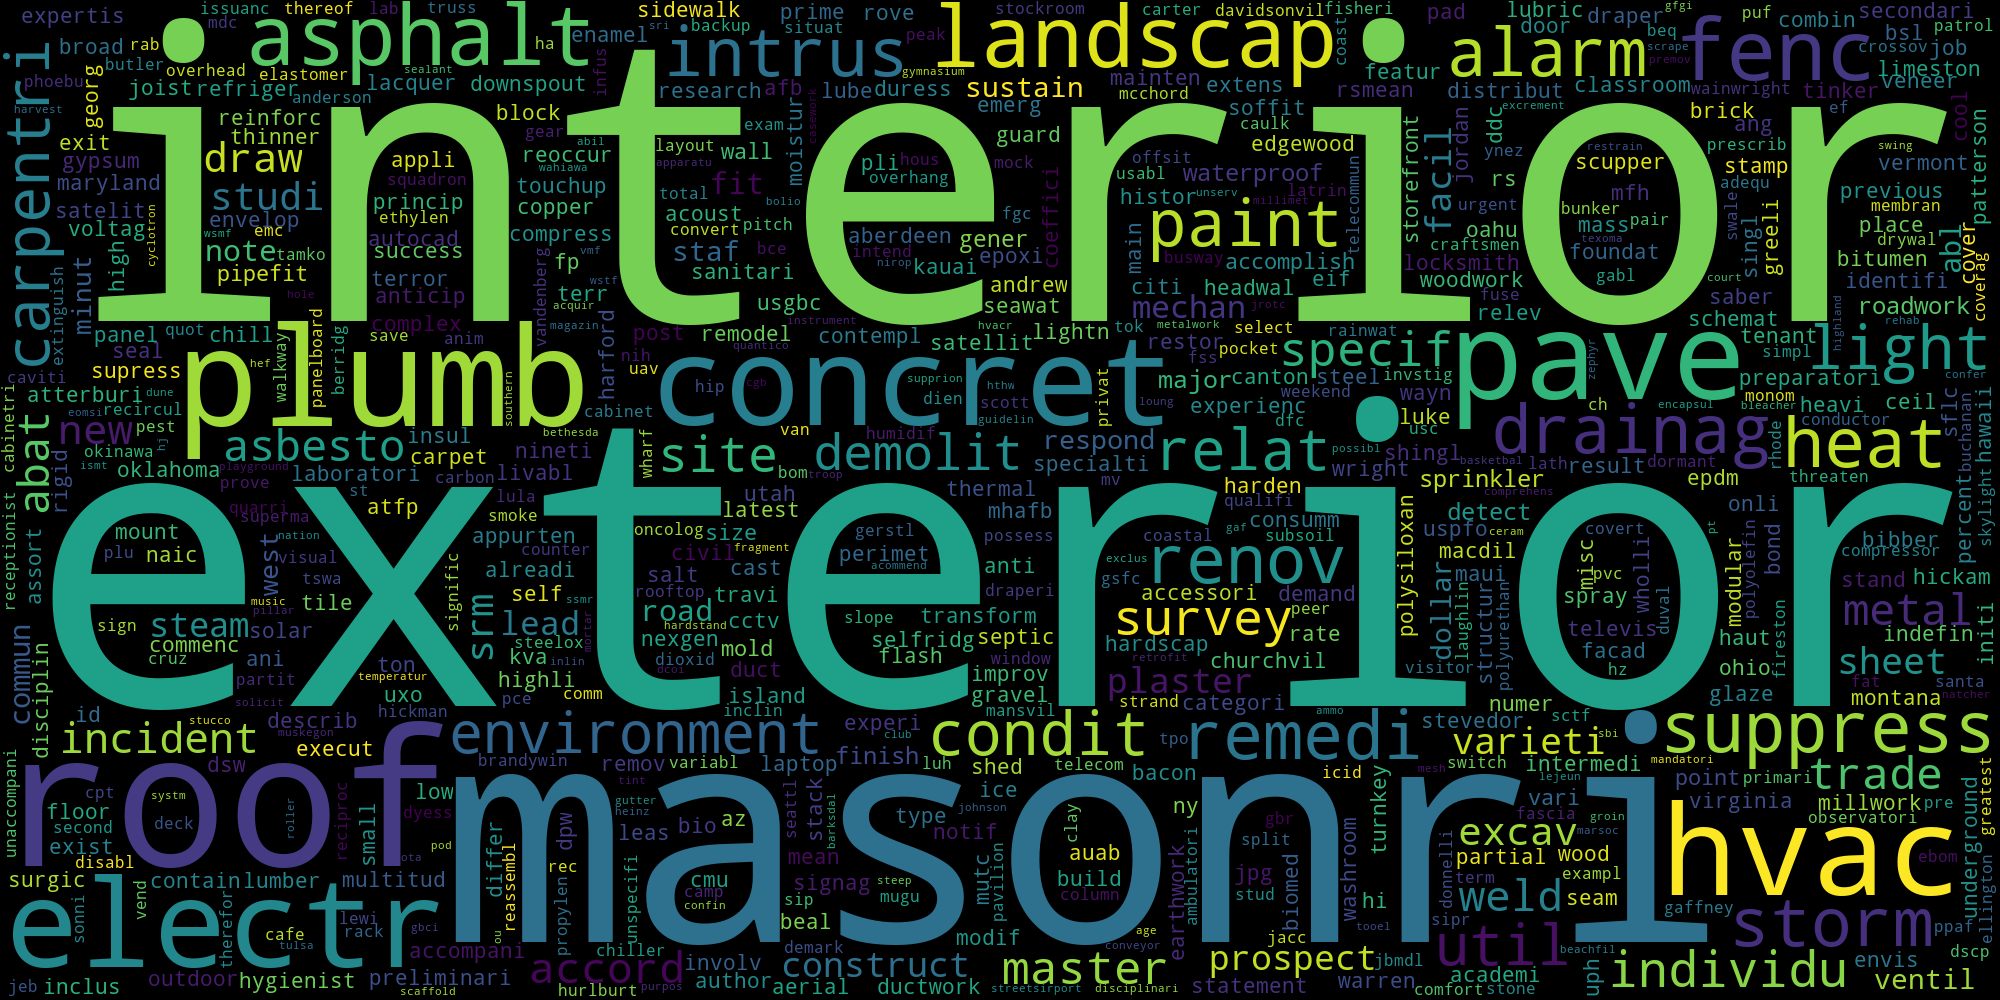

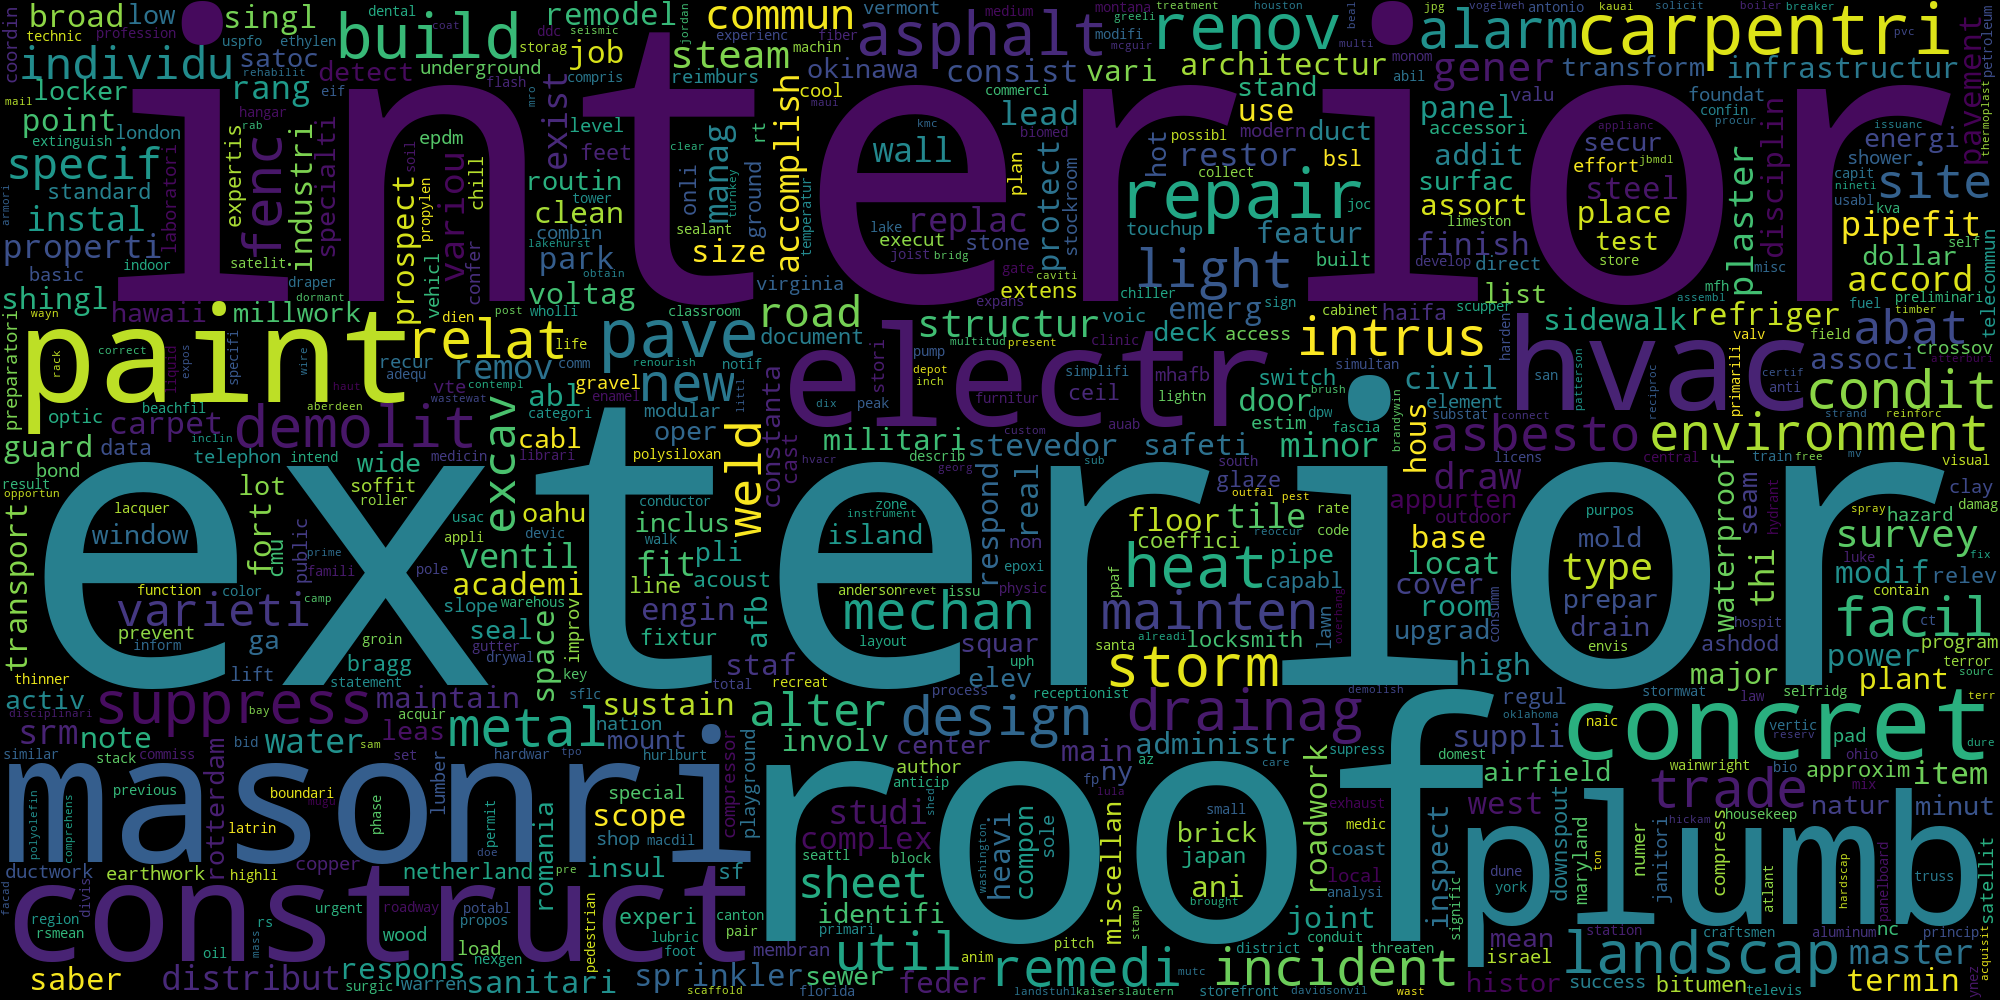

*************************************************************
129454 -> STRENGTH: 100.0
The Department of the Army, National Guard Bureau (NGB), may have a continuing requirement for construction services in the state of Mississippi

PREVIOUS REQUIREMENTS:
Typical work includes, but is not limited to:
Interior and exterior renovations
Heating and air-conditioning
HVAC controls
Plumbing
Fire suppression
Interior and exterior electrical and lighting
Fire and intrusion alarms
Communications
Limited utilities
Site-work
Landscaping
Fencing
Masonry,
Roofing
Concrete
Asphalt paving
Storm drainage
Limited environmental remediation
Construction of new facilities
Surveys
Studies
Design-build
Other related work

*************************************************************
153959 -> STRENGTH: 92.48
The Department of Veterans Affairs, Office of Acquisition & Logistics, National Acquisition Center has a requirement for Indefinite Delivery Indefinite Quantity (IDIQ) Multiple Award task order contrac

In [28]:
topic_i = 31
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

### Topic 2
By looking at the output below, we can label this topic as "General Building Maintenance."  HVAC came up as related to this topic, but to a much lesser degree than topics 13 and 31.  This means that HVAC is relevant to this topic, but it is not highly specific to "General Building Maintenance."

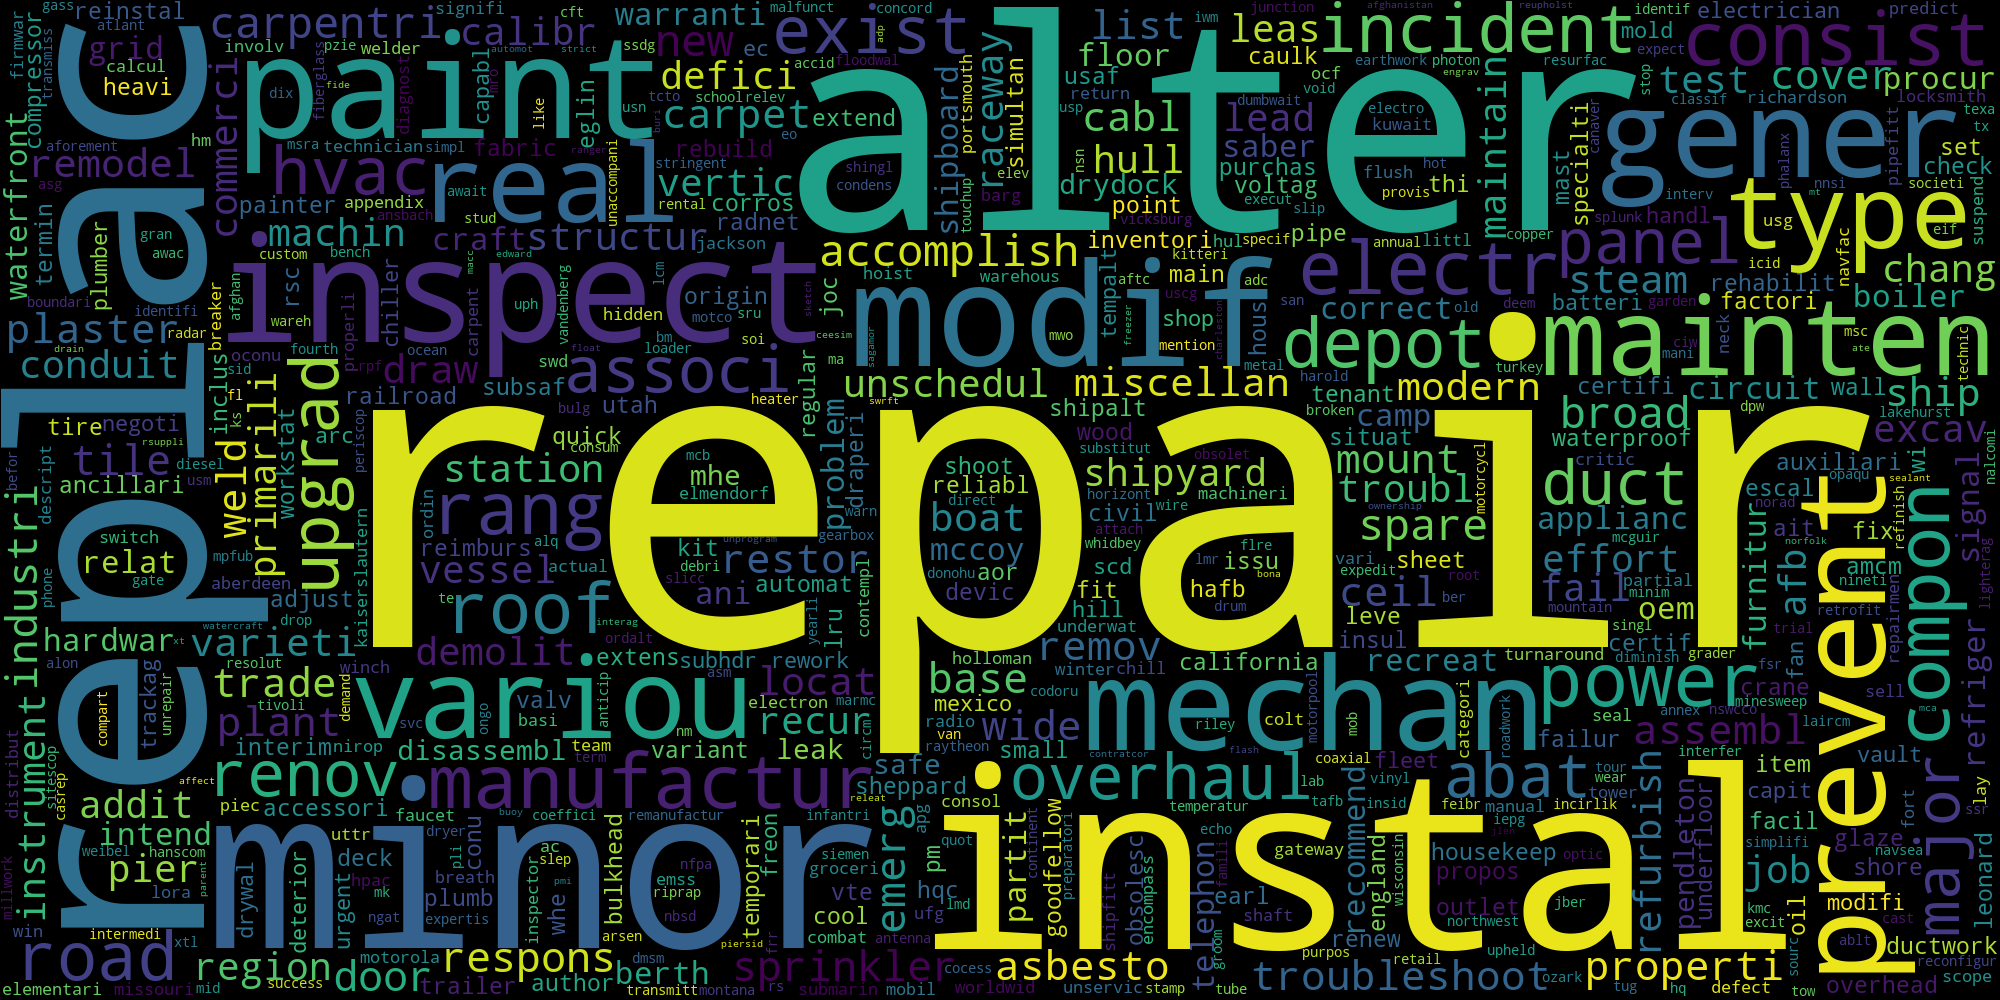

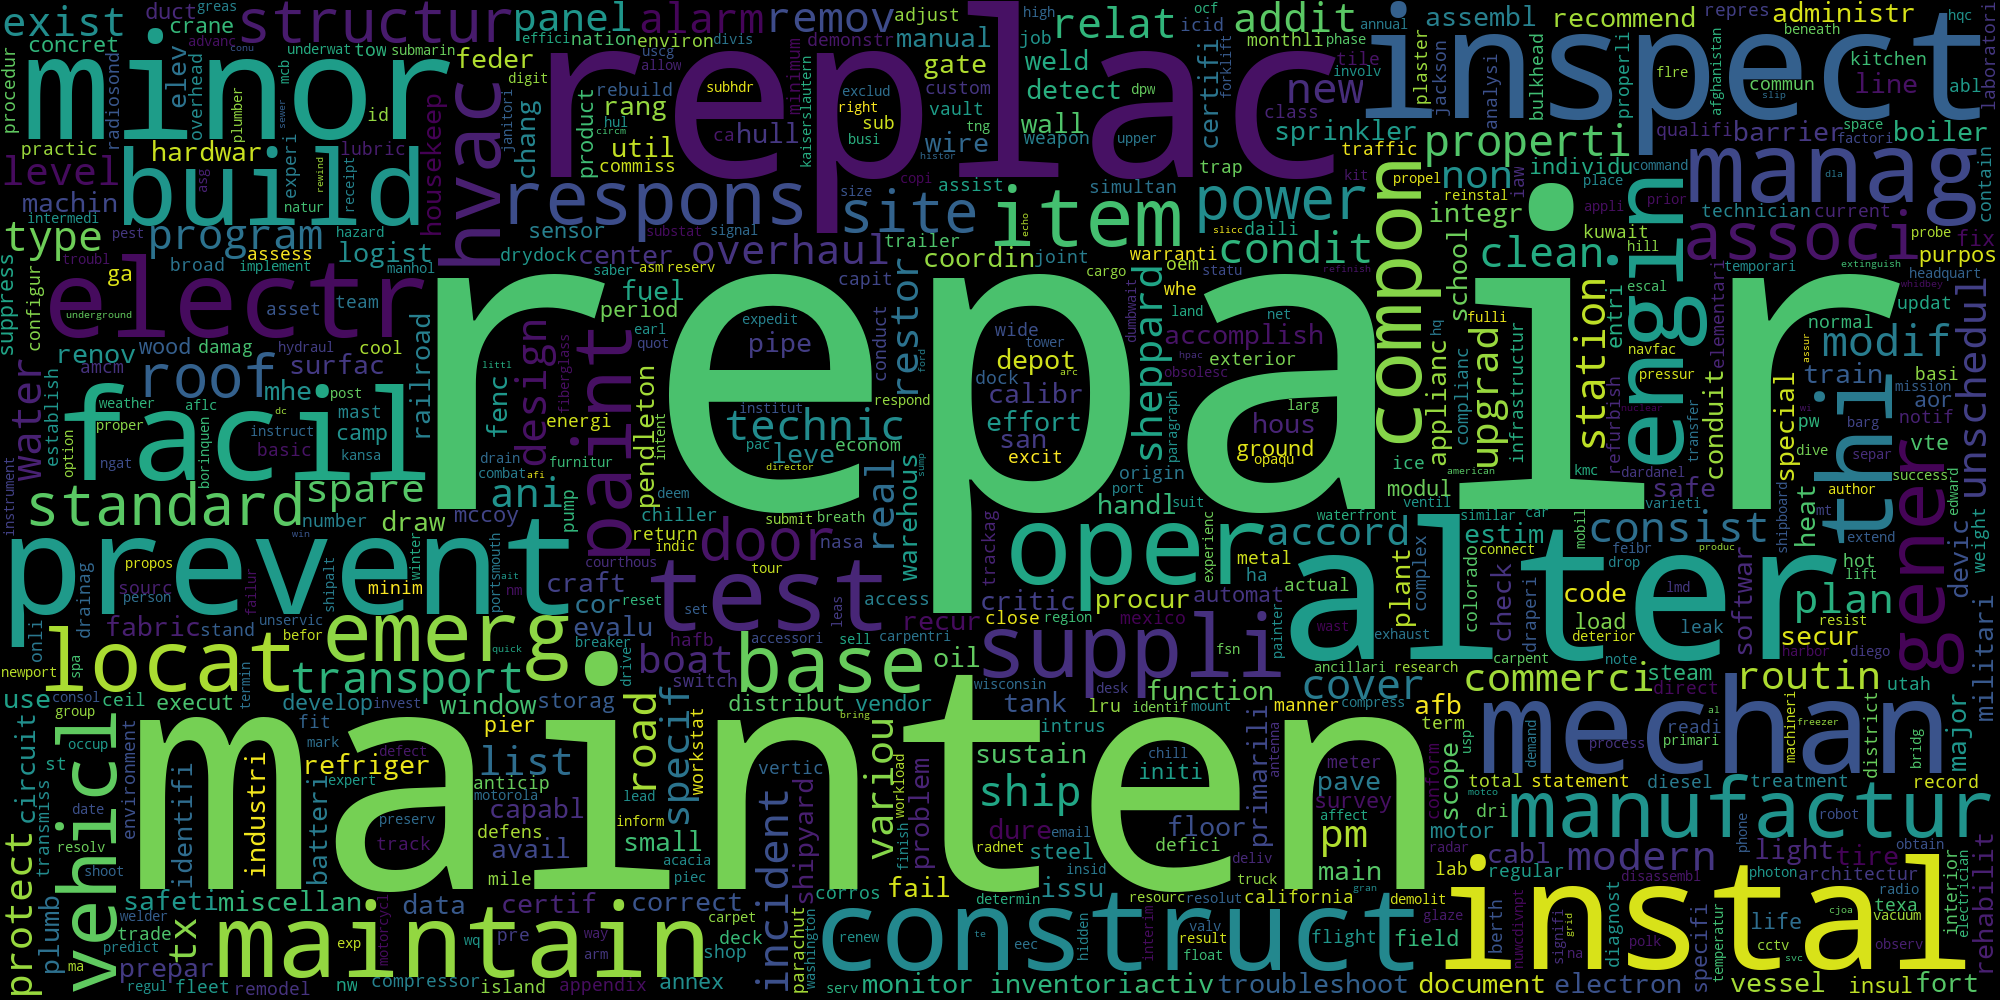

*************************************************************
167135 -> STRENGTH: 100.0
The Department of the Army, Installation Management Command, may have a continuing requirement for maintenance and repair of real property and minor construction at Fort Gordon, Georgia

REQUIREMENTS
Consists of maintenance, repair, and alteration projects

*************************************************************
165459 -> STRENGTH: 96.91
The General Services Administration, on behalf of the Department of the Air Force, Air Force Medical Service, Air Force Medical Support Agency has a continuing requirement for Medical Treatment Facility operations & maintenance

REQUIREMENTS
These facilities and systems require ongoing scheduled preventative maintenance, unscheduled service and repair, as well as minor construction (repair and alteration) work.

*************************************************************
130147 -> STRENGTH: 85.57
PREVIOUS REQUIREMENTS                                         

In [27]:
topic_i = 2
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

## HVAC Summary
We can identify the top general topics where the term "HVAC" is significant.  In this case, there happened to be two general topics (13 and 31) that were highly related to HVAC and it was not necessary to split the general topics into smaller sub-topics.  But happens in a case where it is necessary to further divide a general topic into sub-topics?  We will explore that in the next section.

## Agile Software Development

In [149]:
term_search("agil", H_normalized, tfidf)

36 = 10.55 %
12 = 5.65 %
 5 = 2.46 %
 4 = 0.14 %
 9 = 0.1 %


We have identified the top general topics that contain the term "agil" (the stem of "agile").  The strength in the top topic isn't nearly as strong as it was for "HVAC" in the previous example.  This indicates that these general topics need to be broken down further to identify a strong "agile" topic.

### Topic 36
This topic can be labeled as "IT Enterprise Solutions."  Agile development strategies are commonly used in this area of work, so we are sure to find a "agile" sub-topic within this general topic.

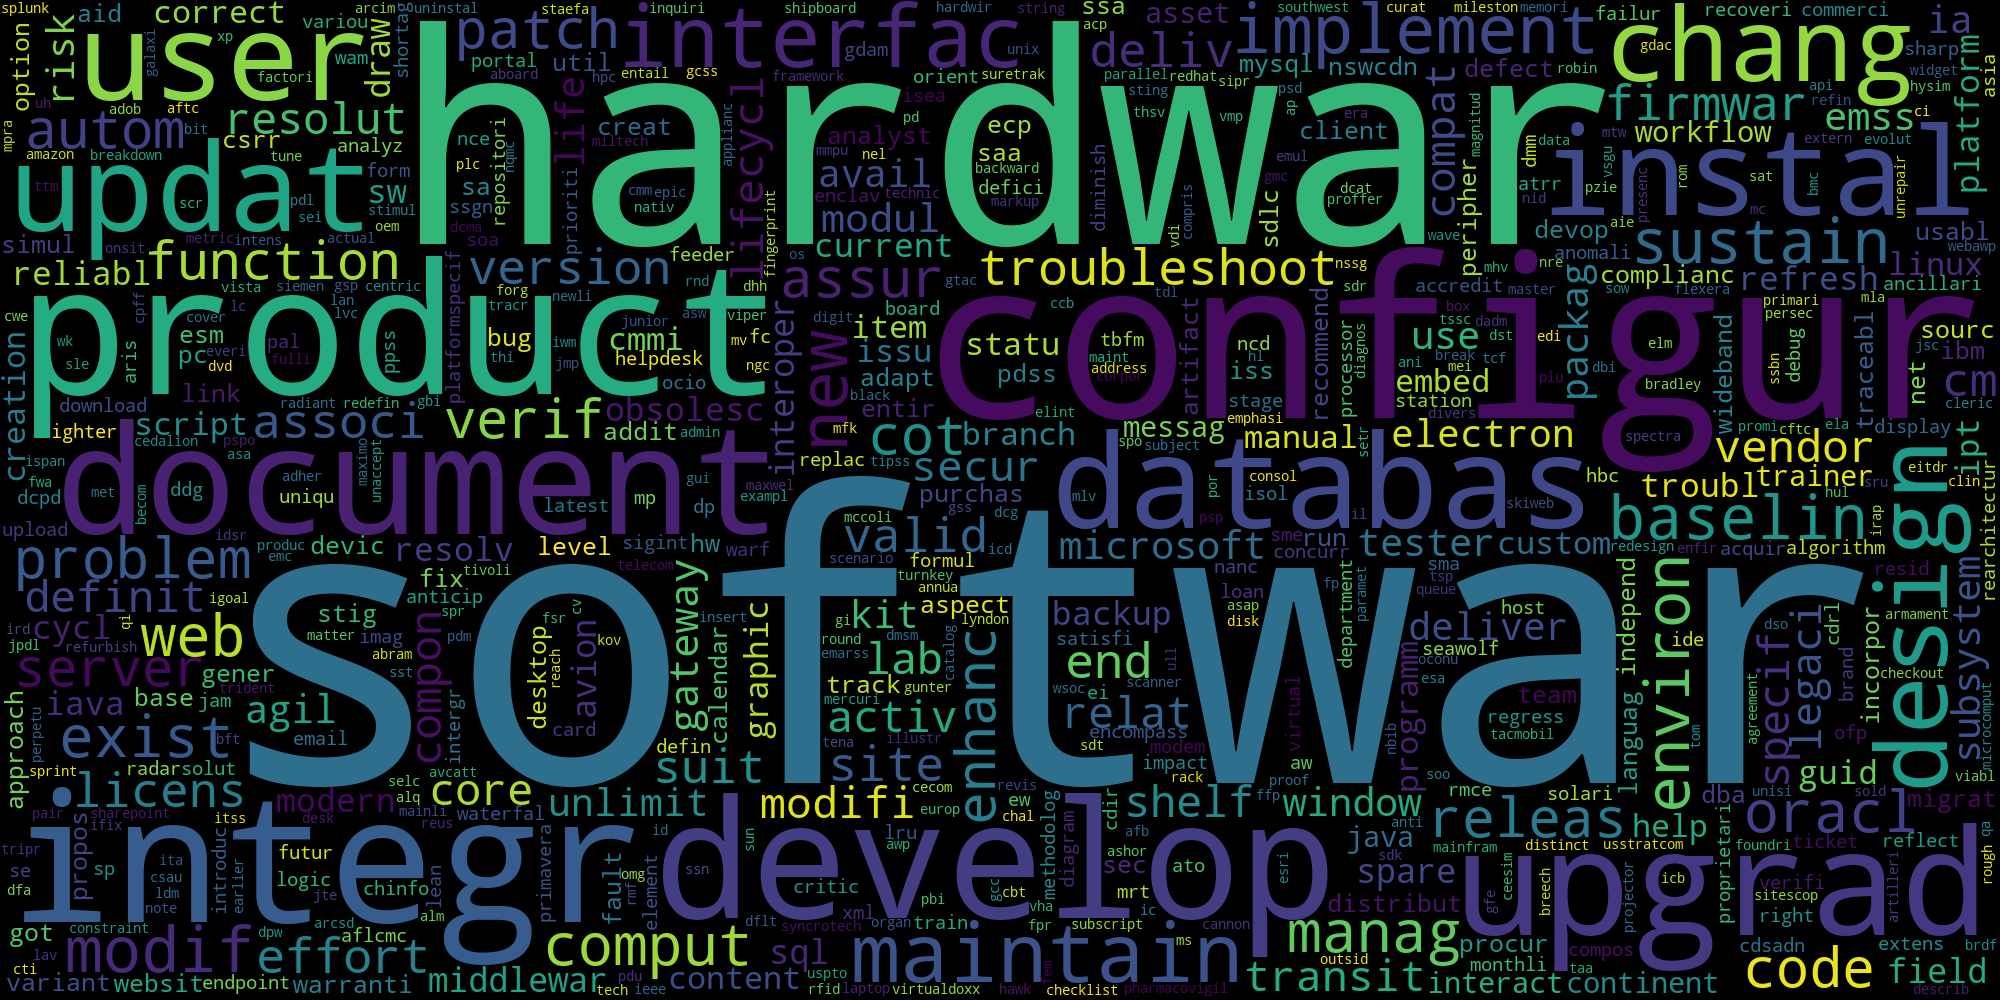

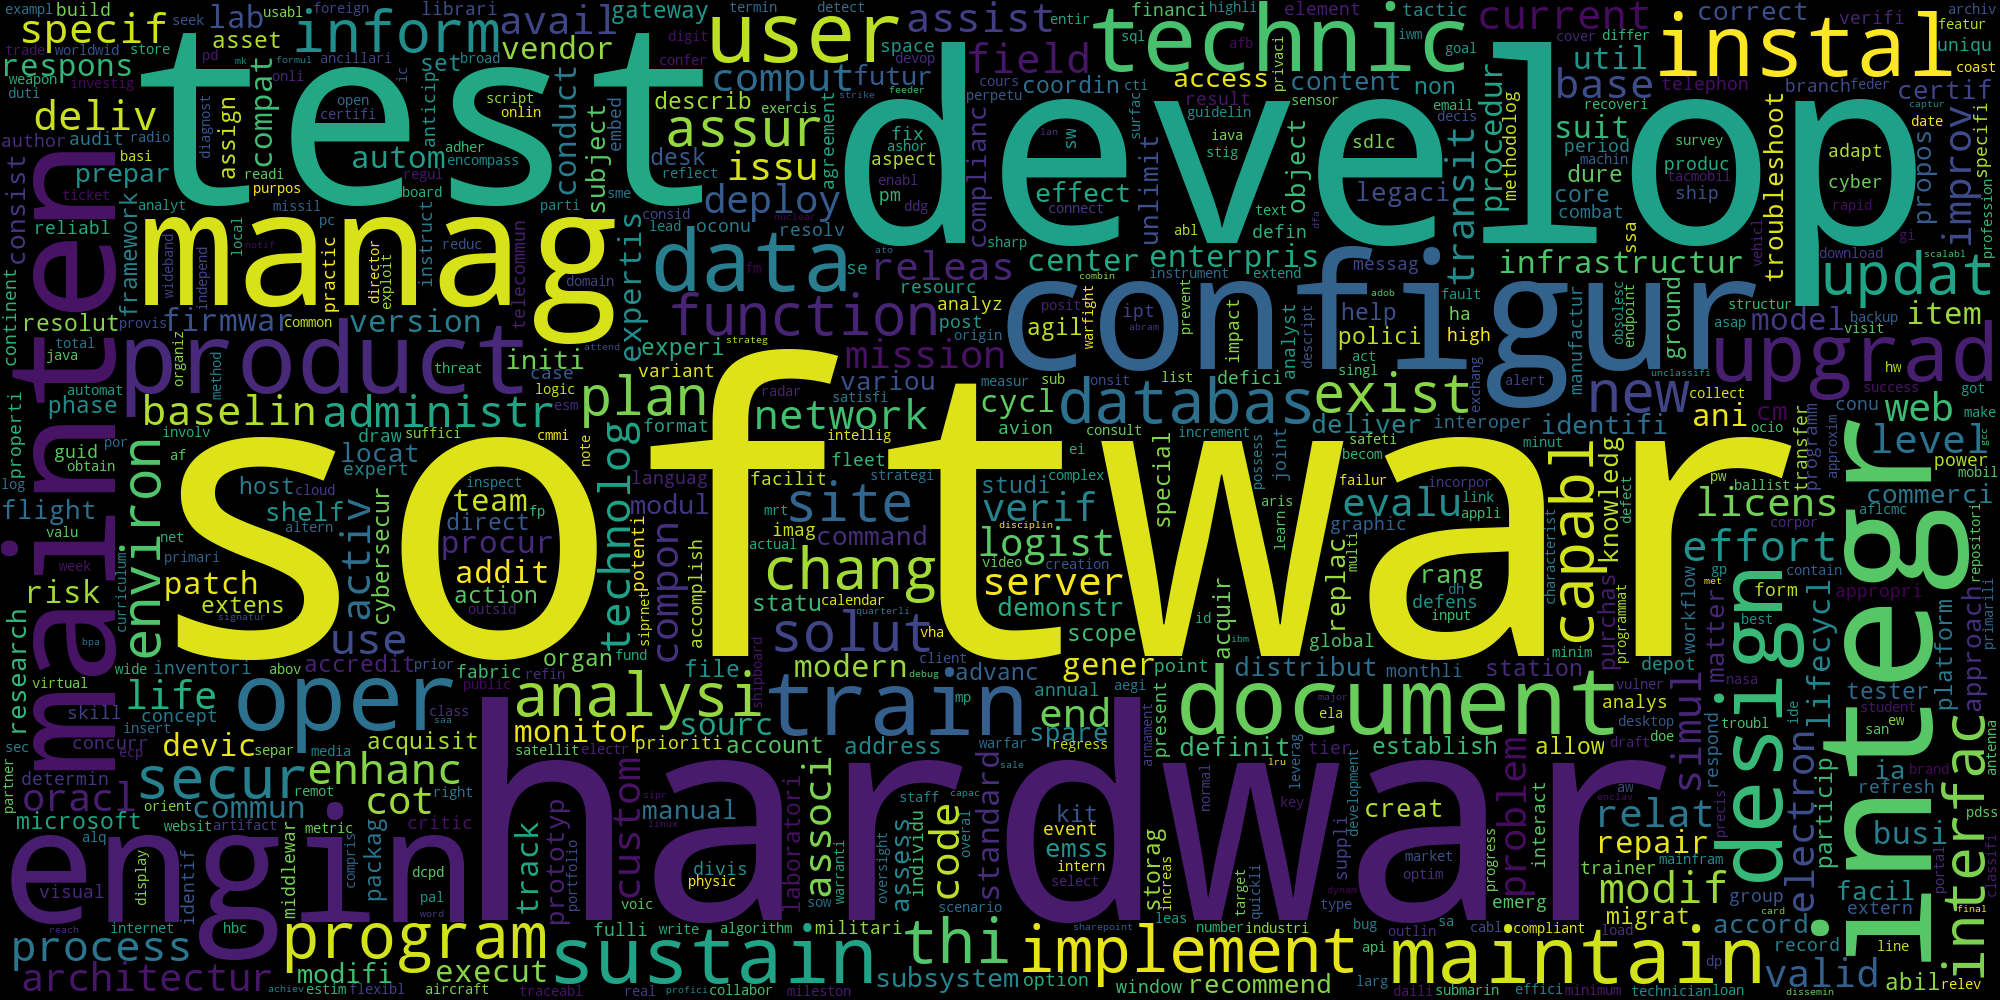

*************************************************************
138913 -> STRENGTH: 100.0
The Department of Defense (DoD), Defense Logistics Agency (DLA), has a requirement for Managed Print Services Fleet Assessment Software

REQUIREMENTS:
The contractor shall:
Provide documentation on the hardware requirements to run the MPS software, in addition to, server space, network bandwidth, and other network resources or network software required to support the software
Provide an installation and configuration guide describing the mitigation or compliance of security standards
Provide annual software maintenance and technical support
Provide updates and patches to keep software compliant with future IA requirements
Diagnose and resolve problems that arise with the software
Provide training and materials
Provide on-site assistance to install and configure the software

*************************************************************
147427 -> STRENGTH: 98.5
The Department of the Navy has a requir

In [182]:
topic_i = 5
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf, True, 2)

### Limit our corpus to the documents only within Topic 26

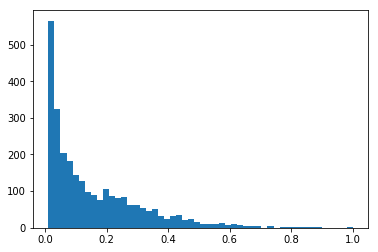

In [176]:
it = W[:, 5]
it_normalized = it / it.max(axis=0)
_ = plt.hist(it_normalized[it_normalized > 0.01], bins=50)

In [177]:
threshold = .1
it_i = it_normalized > threshold
it_tfidf = tfidf_corpus[it_i]
it_corpus = corpus[it_i]
it_doc_ids = doc_ids[it_i]
print(it_tfidf.shape[0], "documents relating to 'IT'.")

1379 documents relating to 'IT'.


### Determine the number of sub-topics to choose

In [178]:
# topic_search(3, 100, construction_tfidf)

In [184]:
it_nmf = NMF(n_components=10, max_iter=666, random_state=666)
it_W = it_nmf.fit_transform(it_tfidf)
it_H = it_nmf.components_
it_H_normalized = it_H / it_H.max(axis=1).reshape((-1, 1))
it_W_max = it_W.max(axis=0)
it_W_normalized = it_W / it_W_max
print(it_nmf.n_iter_, "iterations")

130 iterations


In [185]:
term_search("agil", it_H_normalized, tfidf)

 7 = 22.35 %
 8 = 17.58 %
 9 = 9.19 %
 3 = 1.11 %


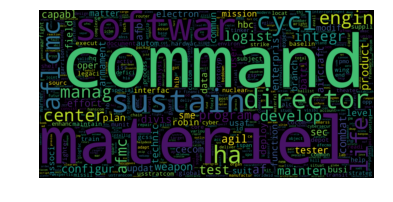

*************************************************************
114713 -> STRENGTH: 29.75
The Department of the Air Force, Air Force Materiel Command (AFMC), Air Force Life Cycle Center (AFLCMC), C2ISR Directorate, COCOM C2 Division has a continuing requirement for Global Strike and Product Support (GSPS) Software

REQUIREMENTS
The contractor shall perform full suite of engineering, software sustainment and/or development services to provide all tasks required the GSPS 2 software for AFLCMC-HBC

*************************************************************
166312 -> STRENGTH: 26.41
The Department of the Air Force, Air Force Materiel Command, Air Force Life Cycle Management Center (AFLCMC), Business and Enterprise Systems Directorate, Business Systems Sustainment Division (AFLCMC/HIB) has a requirement for Program Office configuration management, user training, functional testing, business analysis, and subject matter expertise

BACKGROUND
BaS&E captures all aspects of AF expeditionary/ga

In [187]:
topic_i = 8
wc = WordCloud(background_color="black", max_words=666, width=2000, height=1000)
wc.fit_words({vocabulary[word_i]: it_H[topic_i, word_i] for word_i in range(it_H.shape[1]) if it_H[topic_i, word_i]})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

top7(topic_i, it_W, it_corpus, it_doc_ids, tfidf, it_nmf, False, 2)

In [44]:
wc.to_image().show()

### Find other documents in the HVAC sub-topic

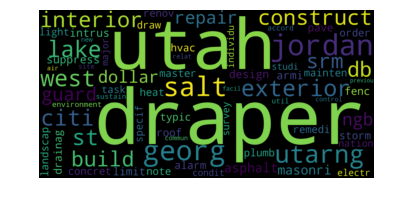

0 -> 0.0015412411464525637
1 -> 0.0
2 -> 0.5482003035399684
3 -> 0.0
4 -> 0.0
5 -> 0.04046329825192404
6 -> 0.0
7 -> 0.0
8 -> 0.0
9 -> 0.04907020691358635
 The Department of the Army, Army National Guard (NGB), Utah Army National Guard (UTARNG), may have a continuing requirement for design-build (DB) construction service for maintenance, repair, construction and design-build services at Salt Lake City, Draper, West Jordan, and St. George, Utah. PREVIOUS REQUIREMENTS  Maintenance, repair, construction and design-build services at Salt Lake City, Draper, West Jordan, and St. George, Utah. Typical work includes, but is not be limited to:  Interior and exterior renovations  Heating and air-conditioning  HVAC controls  Plumbing  Fire suppression  Interior and exterior electrical and lighting  Fire and intrusion alarms  Communications  Limited utilities  Site-work  Landscaping  Fencing  Masonry  Roofing  Concrete  Asphalt paving  Storm drainage  Limited environmental remediation  Constructio

In [37]:
doc_i = 2

wc = WordCloud(background_color="black", max_words=666, width=2000, height=1000)
wc.fit_words({vocabulary[word_i]: construction_tfidf[doc_i, word_i] for word_i in range(construction_tfidf.shape[1]) if construction_tfidf[doc_i, word_i]})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

doc = construction_corpus[doc_i]
doc_topics = construction_W[doc_i] / construction_W_max
[print(i, "->", x) for i, x in enumerate(doc_topics)]
print(doc)

In [38]:
wc.to_image().show()

# Build model from query

In [194]:
del corpus_full
del doc_ids
del corpus
del tfidf_corpus
del nmf
del H
del W
del it
del it_nmf
del it_tfidf
del it_corpus

NameError: name 'corpus_full' is not defined

In [4]:
query = """
           SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description ILIKE('%agile%')
        """
doc_ids_query, corpus_query = get_query_corpus(query, True)
tfidf_corpus_query = tfidf.transform(corpus_query)

Loading corpus...
 -> 167 documents loaded!


In [188]:
# topic_search(3, 100, tfidf_corpus_query)

In [5]:
nmf_query = NMF(n_components=5, max_iter=666, random_state=666)
W_query = nmf_query.fit_transform(tfidf_corpus_query)
H_query = nmf_query.components_
W_max_query = W_query.max()

In [9]:
top7(4, W_query, corpus_query, doc_ids_query, tfidf, nmf_query, False)

*************************************************************
159231 -> STRENGTH: 49.02
Enterprise Resource Planned Systems International, LLC., and NCI Information Systems, Inc., are fulfilling the Department of Homeland Security (DHS), US Citizenship and Immigration Services (USCIS) continuing requirement for Flexible Agile Development Services (FADS) III

USCIS TDD is looking for vendors to provide highly skilled Agile development teams for IT development and operations and maintenance of the Electronic Immigration System using Scrum, OpenShift, microservices and other Agile and Lean processes

*************************************************************
157796 -> STRENGTH: 48.61
The Department of Homeland Security (DHS), United States Citizenship and Immigration Services (USCIS), Office of Information Technology (OIT) has a requirement for forward-thinking, modern Development, Security, and Operations (DEVSECOPs) services

Citizenship Immigration Services (USCIS) Office of Informa